In [1]:
import numpy as np
import simulators.jla_supernovae.jla_simulator as jla
import pydelfi.ndes as ndes
import pydelfi.delfi as delfi
import pydelfi.score as score
import pydelfi.priors as priors
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

In [2]:
import pylab as plt
import pyccl as ccl
import scipy
from scipy.interpolate import interp1d

import matplotlib
%matplotlib inline

import time
import importlib

print("CCL version you are using:",ccl.__version__)

CCL version you are using: 2.1.0


In [3]:
font_config = {"size" : 10,
               "family" : "serif"}

matplotlib.rc("font", **font_config)
matplotlib.rc("text", usetex=True)
# Move title to make space for exponents of y axis
matplotlib.rc("axes", titlepad=5) 
matplotlib.rc("axes", titlesize="medium") 

# Make the figures bigger in the notebook
matplotlib.rc("figure", dpi=150)

color_map = plt.get_cmap("tab10")

paper_textwidth = 7.125
fig_size = (paper_textwidth/2, 2.6)

plot_adjust = dict(left=0.2, top=0.9, bottom=0.2)

In [4]:
import simulators.mass_function_n_counts.simulator_trapz_m500 as n_counts_simulator
importlib.reload(n_counts_simulator)

<module 'simulators.mass_function_n_counts.simulator_trapz_m500' from '/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_m500.py'>

## Set up priors on params of interest (for now): {$\Omega_{m}h^{2} = \Omega_{cdm}h^{2} + \Omega_{b}h^{2}$, $\sigma_{8}$, $h$, $n_{s}$, $w_{0}$}

In [5]:
lower = np.array([0.1125, 0.020, 0.6])
upper = np.array([0.1275, 0.024, 1.1])
prior = priors.Uniform(lower, upper)

In [6]:
theta_fiducial = np.array([0.1197, 0.02222, 0.76])


## Define mass calibration parameters

In [7]:
mass_calibration_param_names = ['\\alpha_{Y}', '\\beta_{Y}', '\\gamma_{Y}', 'Y_{*}', 'M_{*}', 
                                '\\alpha_{\sigma}', '\\gamma_{\sigma}', '\\sigma_{log Y_{0}}']
theta_fiducial_mass_calibration = np.array([1.8, 0., 0., 2.4e-10, 1e14, 0., 0., 0.127])

In [8]:
N_countsSimulator = n_counts_simulator.Model()

0.52322252 s


## Get Cosmology and HMF 

In [9]:
# Define a mass definition object
hm_def = ccl.halos.MassDef(500, 'critical')
cosmo_ccl = N_countsSimulator.cosmo(theta_fiducial)
nM = ccl.halos.MassFuncTinker08(cosmo_ccl, mass_def=hm_def)

In [10]:
def compute_mass_calibration_params(theta_mass_calibration, M_500, z):
    t1 = time.process_time()
    alpha_Y = theta_mass_calibration[0]
    beta_Y = theta_mass_calibration[1]
    gamma_Y = theta_mass_calibration[2]
    
    Y_star = theta_mass_calibration[3]
    M_star = theta_mass_calibration[4]
    
    alpha_sigma = theta_mass_calibration[5]
    gamma_sigma = theta_mass_calibration[6]
    sigma_logY0 = theta_mass_calibration[7]
    
    scale_fact_a = 1/(1+z)
    #t2 = time.process_time()
    
    E_z = (ccl.background.h_over_h0(cosmo_ccl, scale_fact_a)**(2/3))
    if ccl.background.comoving_radial_distance(cosmo_ccl, scale_fact_a) == 0:
        D_A_z = 0.
    else:
        D_A_z = (ccl.background.comoving_radial_distance(cosmo_ccl, scale_fact_a)/100)**(-2)
   
    mean_Y_500 = Y_star*((M_500/M_star)**alpha_Y)*np.exp(beta_Y*(np.log10(M_500/M_star)**2))*((1+z)**gamma_Y)*E_z*D_A_z
    
    sigma_logY_500 = sigma_logY0*((M_500/M_star)**alpha_sigma)*((1+z)**gamma_sigma)
    
    t2 = time.process_time()
    #print(t2 - t1)
    return mean_Y_500, sigma_logY_500

In [11]:
def compute_probability_Y_500(theta_mass_calibration, Y_500_true, M_500, z):
    t1 = time.process_time()
    
    mean_Y_500, sigma_logY_500 = compute_mass_calibration_params(theta_mass_calibration, M_500, z)
    
    prob_Y_500_true = np.exp(-((np.log10(Y_500_true) - np.log10(mean_Y_500))**2)/(2*(sigma_logY_500**2)))/(np.sqrt(2*np.pi)*sigma_logY_500)
    
    t2 = time.process_time()
    #print(t2 - t1)
    return prob_Y_500_true

In [12]:
mean_Y_500, sigma_logY_500 = compute_mass_calibration_params(theta_fiducial_mass_calibration, 1e15, 0.5)
compute_probability_Y_500(theta_fiducial_mass_calibration, 5e-11, 1e15, 0.5)

3.136997944522371

In [13]:
def Y_500_trapz(theta_mass_calibration, M_500, z, Y_min, Y_max, n_steps_Y = 1000):
    t1 = time.process_time()
    
    Y_steps = np.linspace(Y_min, Y_max, num=n_steps_Y)
    p_Y_true = np.array([compute_probability_Y_500(theta_mass_calibration, Y_500_true, M_500, z)/Y_500_true for Y_500_true in Y_steps])
    #p_Y_true = np.array([compute_probability_Y_500(theta_mass_calibration, Y_500_true, M_500, z) for Y_500_true in Y_steps])
    
    
    integral_trapz = np.trapz(p_Y_true, Y_steps)
    
    t2 = time.process_time()
    #print(t2 - t1)
    return integral_trapz

In [14]:
p_Y_true = Y_500_trapz(theta_fiducial_mass_calibration, 1e15, 0.5, 3e-11, 5e-11, n_steps_Y = 1000)

## Compute number counts with a loop

In [15]:
z_min = np.array([0., 0.25, 0.5, 0.75, 1.])
z_max = np.array([0.25, 0.5, 0.75, 1., 1.5])
n_steps_z = 100
n_bins_z = len(z_min)

In [16]:
Y_bins_limits = [np.logspace(np.log10(8.6e-12), np.log10(3.9e-9), num = 16),
                 np.logspace(np.log10(4.3e-12), np.log10(5.1e-10), num = 15),
                 np.logspace(np.log10(3.1e-12), np.log10(1.8e-10), num = 16),
                 np.logspace(np.log10(3.1e-12), np.log10(1.1e-10), num = 14),
                 np.logspace(np.log10(2.5e-12), np.log10(6.6e-11), num = 13)]

In [17]:
n_steps_M_500 = 100
log10_M_500_steps = np.linspace(6, 16, num = n_steps_M_500)
M_500_steps = 10**log10_M_500_steps

In [18]:
H0 = 100 * 0.69
c = ccl.physical_constants.CLIGHT * 1e-3  # in km/s
counts = []
for n in range(n_bins_z):
    z_steps = np.linspace(z_min[n], z_max[n], num = n_steps_z)
        
    scale_fact_a = 1 / (1 + z_steps)
    H_z = H0 * ccl.background.h_over_h0(cosmo_ccl, scale_fact_a)
    factor = 4 * np.pi * (c / H_z) * (ccl.background.comoving_radial_distance(cosmo_ccl, scale_fact_a) ** 2)
       
    
    for k in range(len(Y_bins_limits[n]) - 1):
        dZ = []
        for i in range(n_steps_z):
            a = 1/(1+z_steps[i])
            hmf = nM.get_mass_function(cosmo_ccl, M_500_steps, a)
            
            Y_500_dM = []
            
            for j in range(n_steps_M_500):
                Y_500_integral = Y_500_trapz(theta_fiducial_mass_calibration, M_500_steps[j], z_steps[i], 
                                             Y_bins_limits[n][k], Y_bins_limits[n][k+1], n_steps_Y = 100)
                Y_500_dM.append(Y_500_integral)
            
            Y_500_dM = np.array(Y_500_dM)
            dn_dM = hmf*Y_500_dM
            M_500_integral = np.trapz(dn_dM, log10_M_500_steps)
            
            dZ.append(M_500_integral*factor[i])
            
        Z_integral = np.trapz(dZ, z_steps)
        counts.append(Z_integral)
        print(n, k)

/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
4 11


In [19]:
len(counts)

69

In [20]:
counts = np.array(counts)
print(counts)

[9.71515551e+03 6.63710787e+03 4.43788626e+03 2.90023461e+03
 1.85063232e+03 1.15260489e+03 7.01000871e+02 4.16925048e+02
 2.43076563e+02 1.39363454e+02 7.88484399e+01 4.41678004e+01
 2.45607765e+01 1.35832685e+01 7.47964329e+00 1.18968596e+04
 7.73542768e+03 4.88169927e+03 2.98026291e+03 1.75366385e+03
 9.90593491e+02 5.34788185e+02 2.74598377e+02 1.33383718e+02
 6.09218025e+01 2.59877509e+01 1.02753886e+01 3.73367687e+00
 1.23459864e+00 5.28808066e+03 3.43173877e+03 2.16851216e+03
 1.33092109e+03 7.91363649e+02 4.54527362e+02 2.51390254e+02
 1.33448269e+02 6.77300284e+01 3.27369306e+01 1.50030434e+01
 6.48727994e+00 2.63355080e+00 9.97725635e-01 3.50639895e-01
 1.24165158e+03 7.01424667e+02 3.81165336e+02 1.98545512e+02
 9.87306286e+01 4.66900318e+01 2.08944762e+01 8.80574858e+00
 3.47644079e+00 1.27751431e+00 4.34516542e-01 1.35733438e-01
 3.86735458e-02 3.89051790e+02 1.94546813e+02 9.29006543e+01
 4.22080219e+01 1.81541260e+01 7.36025598e+00 2.79700683e+00
 9.90342216e-01 3.248508

In [33]:
N_counts = [np.array(counts[:15]), np.array(counts[15:29]),
            np.array(counts[29:44]), np.array(counts[44:57]),
            np.array(counts[57:])]

In [44]:
N_counts

[array([9.71515551e+03, 6.63710787e+03, 4.43788626e+03, 2.90023461e+03,
        1.85063232e+03, 1.15260489e+03, 7.01000871e+02, 4.16925048e+02,
        2.43076563e+02, 1.39363454e+02, 7.88484399e+01, 4.41678004e+01,
        2.45607765e+01, 1.35832685e+01, 7.47964329e+00]),
 array([1.18968596e+04, 7.73542768e+03, 4.88169927e+03, 2.98026291e+03,
        1.75366385e+03, 9.90593491e+02, 5.34788185e+02, 2.74598377e+02,
        1.33383718e+02, 6.09218025e+01, 2.59877509e+01, 1.02753886e+01,
        3.73367687e+00, 1.23459864e+00]),
 array([5.28808066e+03, 3.43173877e+03, 2.16851216e+03, 1.33092109e+03,
        7.91363649e+02, 4.54527362e+02, 2.51390254e+02, 1.33448269e+02,
        6.77300284e+01, 3.27369306e+01, 1.50030434e+01, 6.48727994e+00,
        2.63355080e+00, 9.97725635e-01, 3.50639895e-01]),
 array([1.24165158e+03, 7.01424667e+02, 3.81165336e+02, 1.98545512e+02,
        9.87306286e+01, 4.66900318e+01, 2.08944762e+01, 8.80574858e+00,
        3.47644079e+00, 1.27751431e+00, 4.34516542

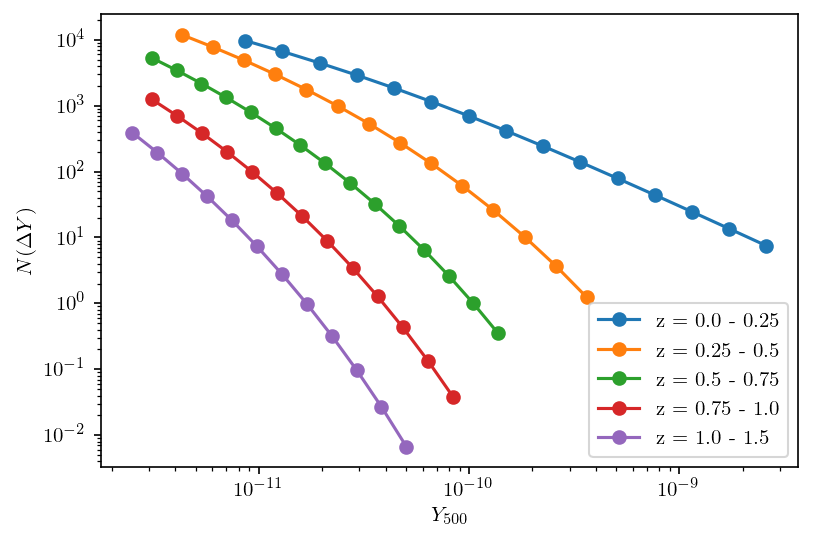

In [41]:
plt.figure()
plt.ylabel(r'$N(\Delta Y)$')
plt.xlabel(r'$Y_{500}$')
plt.xscale('log')
plt.yscale('log')
for i in range(len(z_max)):
    plt.plot(Y_bins_limits[i][:-1], N_counts[i], c=color_map(i), marker = 'o', 
             label = 'z = {z_min} - {z_max}'.format(z_min = z_min[i], z_max = z_max[i]))
plt.legend(loc = 'best')

In [ ]:
H0 = 100 * 0.69
c = ccl.physical_constants.CLIGHT * 1e-3  # in km/s
counts = []
for n in range(n_bins_z):
    z_steps = np.linspace(z_min[n], z_max[n], num = n_steps_z)
        
    scale_fact_a = 1 / (1 + z_steps)
    H_z = H0 * ccl.background.h_over_h0(cosmo_ccl, scale_fact_a)
    factor = 4 * np.pi * (c / H_z) * (ccl.background.comoving_radial_distance(cosmo_ccl, scale_fact_a) ** 2)
       
    
    for k in range(len(Y_bins_limits[n]) - 1):
        dZ = []
        for i in range(n_steps_z):
            a = 1/(1+z_steps[i])
            hmf = nM.get_mass_function(cosmo_ccl, M_500_steps, a)
            
            Y_500_dM = []
            
            for j in range(n_steps_M_500):
                Y_500_integral = Y_500_trapz(theta_fiducial_mass_calibration, M_500_steps[j], z_steps[i], 
                                             Y_bins_limits[n][k], Y_bins_limits[n][k+1], n_steps_Y = 100)
                Y_500_dM.append(Y_500_integral)
            
            Y_500_dM = np.array(Y_500_dM)
            dn_dM = hmf*Y_500_dM
            M_500_integral = np.trapz(dn_dM, log10_M_500_steps)
            
            dZ.append(M_500_integral*factor[i])
            
        Z_integral = np.trapz(dZ, z_steps)
        counts.append(Z_integral)
        print(n, k)

## stuff from simulator.py

In [18]:
# Define a mass definition object
hm_def = ccl.halos.MassDef(500, 'critical')
cosmo_ccl = N_countsSimulator.cosmo(theta_fiducial)
nM = ccl.halos.MassFuncTinker08(cosmo_ccl, mass_def=hm_def)

In [19]:
def halo_mass_function(cosmo_ccl, masses, z):
    scale_fact_a = 1 / (1 + z)
    hm_def = ccl.halos.MassDef(500, 'critical')
    
    mass_funct = ccl.halos.MassFuncTinker08(cosmo_ccl, mass_def=hm_def)
        
    dn_dM = np.array([mass_funct.get_mass_function(cosmo_ccl, masses, a) for a in scale_fact_a])
    return dn_dM

In [20]:
def n_counts_trapz_integral(cosmo_ccl, z_steps, mass_grid, theta):
    H0 = 100 * 0.69
    c = ccl.physical_constants.CLIGHT * 1e-3  # in km/s
        
    scale_fact_a = 1 / (1 + z_steps)
    H_z = H0 * ccl.background.h_over_h0(cosmo_ccl, scale_fact_a)
    factor = 4 * np.pi * (c / H_z) * (ccl.background.comoving_radial_distance(cosmo_ccl, scale_fact_a) ** 2)
        
    dN_dlog10Mdz = halo_mass_function(cosmo_ccl, mass_grid.flatten(), z_steps) 
    dN_dlog10Mdz = dN_dlog10Mdz.T.reshape((mass_grid.shape[0], mass_grid.shape[1], z_steps.shape[0]), order='C')
    N_counts_dz = factor[np.newaxis, np.newaxis, :] * np.trapz(dN_dlog10Mdz, np.log10(mass_grid[:, :, np.newaxis]), axis=1)
        
    integral_trapz = np.trapz(N_counts_dz, z_steps, axis=-1)
    return integral_trapz

In [21]:
def all_n_counts_trapz(z_min, z_max, log10masses, theta, n_steps_z=100, n_steps_masses=1000):
    N_counts_true = np.zeros((log10masses.shape[1], len(z_min)))
        
    log10mass_mins = log10masses[0]
    log10mass_maxs = log10masses[1]
        
    nm_bins = log10mass_maxs.shape[0]
    delta_bin = log10mass_maxs - log10mass_mins
    mass_grid = 10 ** (log10mass_mins[:, np.newaxis] +
                        np.linspace(0, 1, n_steps_masses) * delta_bin[:, np.newaxis])
    print(mass_grid.shape)
    print(mass_grid.flatten().shape)
    
    cosmo_ccl = N_countsSimulator.cosmo(theta)
    t1 = time.process_time()
    for i in range(len(z_min)):
        z_steps = np.linspace(z_min[i], z_max[i], num=n_steps_z)

        N_counts_temp = n_counts_trapz_integral(cosmo_ccl, z_steps, mass_grid, theta)
        N_counts_true[:, i] = N_counts_temp
            
    t2 = time.process_time()
    print(str(t2-t1) + ' s')

    #shape_new = N_counts_true.shape[0] * N_counts_true.shape[1]
    #N_counts_true = N_counts_true.reshape(shape_new)
    return N_counts_true, mass_grid

In [22]:
log10masses = np.linspace(14, 16, num = 5)
z_min = np.linspace(0.1, 0.9, num = 5)
z_max = np.linspace(0.2, 1.0, num = 5)
log10masses_2d = np.stack((log10masses[:-1], log10masses[1:]))

In [23]:
N_counts_true, mass_grid = all_n_counts_trapz(z_min, z_max, log10masses_2d, theta_fiducial)

(4, 1000)
(4000,)
0.6215326379999997 s


In [24]:
mass_grid

array([[1.00000000e+14, 1.00115311e+14, 1.00230755e+14, ...,
        3.15499735e+14, 3.15863541e+14, 3.16227766e+14],
       [3.16227766e+14, 3.16592411e+14, 3.16957477e+14, ...,
        9.97697764e+14, 9.98848219e+14, 1.00000000e+15],
       [1.00000000e+15, 1.00115311e+15, 1.00230755e+15, ...,
        3.15499735e+15, 3.15863541e+15, 3.16227766e+15],
       [3.16227766e+15, 3.16592411e+15, 3.16957477e+15, ...,
        9.97697764e+15, 9.98848219e+15, 1.00000000e+16]])

## Step 1

In [25]:
Y_bins_limits = [np.logspace(np.log10(8.6e-12), np.log10(3.9e-9), num = 16),
                 np.logspace(np.log10(4.3e-12), np.log10(5.1e-10), num = 15),
                 np.logspace(np.log10(3.1e-12), np.log10(1.8e-10), num = 16),
                 np.logspace(np.log10(3.1e-12), np.log10(1.1e-10), num = 14),
                 np.logspace(np.log10(2.5e-12), np.log10(6.6e-11), num = 13)]

In [26]:
z_min = np.array([0., 0.25, 0.5, 0.75, 1.])
z_max = np.array([0.25, 0.5, 0.75, 1., 1.5])
n_steps_z = 100
n_bins_z = len(z_min)


n_steps_M_500 = 100
log10_M_500_steps = np.linspace(6, 16, num = n_steps_M_500)
M_500_steps = 10**log10_M_500_steps

In [68]:
def compute_mass_calibration_params_array(theta_mass_calibration, M_500, z):
    t1 = time.process_time()
    alpha_Y = theta_mass_calibration[0]
    beta_Y = theta_mass_calibration[1]
    gamma_Y = theta_mass_calibration[2]
    
    Y_star = theta_mass_calibration[3]
    M_star = theta_mass_calibration[4]
    
    alpha_sigma = theta_mass_calibration[5]
    gamma_sigma = theta_mass_calibration[6]
    sigma_logY0 = theta_mass_calibration[7]
    
    scale_fact_a = 1/(1+z)
    #t2 = time.process_time()
    
    E_z = (ccl.background.h_over_h0(cosmo_ccl, scale_fact_a)**(2/3))
    #if ccl.background.comoving_radial_distance(cosmo_ccl, scale_fact_a) == 0:
     #   D_A_z = np.zeros(len(z))
    #else:
    D_A_z = (ccl.background.comoving_radial_distance(cosmo_ccl, scale_fact_a)/100)**(-2)
   
    mean_Y_500 = Y_star*((M_500/M_star)**alpha_Y)*np.exp(beta_Y*(np.log10(M_500/M_star)**2))*((1+z)**gamma_Y)*E_z*D_A_z
    
    sigma_logY_500 = sigma_logY0*((M_500/M_star)**alpha_sigma)*((1+z)**gamma_sigma)
    
    t2 = time.process_time()
    #print(t2 - t1)
    return mean_Y_500, sigma_logY_500

#### for a single combination of mass and redshift

In [69]:
compute_mass_calibration_params_array(theta_fiducial_mass_calibration, 1e14, 0.5)

(7.804377283092591e-13, 0.127)

#### check with a loop

In [76]:
z_array = np.linspace(0.5, 0.75, num = 10)
M_array = np.logspace(14, 15, num = 5)

In [79]:
mean_Y_500_array = np.zeros((len(M_array), len(z_array)))
sigma_logY_500_array =  np.zeros((len(M_array), len(z_array)))

time1 = time.process_time()
for i in range(len(z_array)):
    for j in range(len(M_array)):
        mean_Y_500_array[j][i], sigma_logY_500_array[j][i] = compute_mass_calibration_params_array(theta_fiducial_mass_calibration, M_array[j], z_array[i])
        
time2 = time.process_time()
print('time:' + str(time2 - time1))

time:0.0008190670000001177


In [63]:
mean_Y_500_array

array([[7.80437728e-13, 7.18703341e-13, 6.65583781e-13, 6.19520264e-13,
        5.79294339e-13, 5.43942061e-13, 5.12692451e-13, 4.84922716e-13,
        4.60125204e-13, 4.37882560e-13],
       [2.19957237e-12, 2.02558123e-12, 1.87586997e-12, 1.74604534e-12,
        1.63267328e-12, 1.53303702e-12, 1.44496365e-12, 1.36669791e-12,
        1.29680902e-12, 1.23412073e-12],
       [6.19923723e-12, 5.70886356e-12, 5.28691990e-12, 4.92102438e-12,
        4.60149850e-12, 4.32068537e-12, 4.07246089e-12, 3.85187805e-12,
        3.65490441e-12, 3.47822481e-12],
       [1.74718244e-11, 1.60897636e-11, 1.49005648e-11, 1.38693311e-11,
        1.29687848e-11, 1.21773459e-11, 1.14777543e-11, 1.08560673e-11,
        1.03009202e-11, 9.80296944e-12],
       [4.92422917e-11, 4.53471152e-11, 4.19954975e-11, 3.90890861e-11,
        3.65510018e-11, 3.43204238e-11, 3.23487067e-11, 3.05965549e-11,
        2.90319377e-11, 2.76285217e-11]])

#### try it for an array

In [82]:
z_array = np.linspace(0.5, 0.75, num = 10).reshape(1, 10)
M_array = np.logspace(14, 15, num = 5).reshape(5, 1)


In [83]:
z_array_0 = np.repeat(z_array, 5, axis=0)
M_array_0 = np.repeat(M_array, 10, axis=1)

In [84]:
z_array_flat = z_array_0.flatten()
M_array_flat = M_array_0.flatten()

In [85]:
t1 = time.process_time()
mean_Y_500_flat, sigma_logY_500_flat = compute_mass_calibration_params_array(theta_fiducial_mass_calibration, M_array_flat, z_array_flat)
        
t2 = time.process_time()
print('time:' + str(t2 - t1))

time:0.00019594499999975312


In [86]:
mean_Y_500 = mean_Y_500_flat.reshape(5, 10)
sigma_logY_500 = sigma_logY_500_flat.reshape(5, 10)

In [89]:
mean_Y_500

array([[7.80437728e-13, 7.18703341e-13, 6.65583781e-13, 6.19520264e-13,
        5.79294339e-13, 5.43942061e-13, 5.12692451e-13, 4.84922716e-13,
        4.60125204e-13, 4.37882560e-13],
       [2.19957237e-12, 2.02558123e-12, 1.87586997e-12, 1.74604534e-12,
        1.63267328e-12, 1.53303702e-12, 1.44496365e-12, 1.36669791e-12,
        1.29680902e-12, 1.23412073e-12],
       [6.19923723e-12, 5.70886356e-12, 5.28691990e-12, 4.92102438e-12,
        4.60149850e-12, 4.32068537e-12, 4.07246089e-12, 3.85187805e-12,
        3.65490441e-12, 3.47822481e-12],
       [1.74718244e-11, 1.60897636e-11, 1.49005648e-11, 1.38693311e-11,
        1.29687848e-11, 1.21773459e-11, 1.14777543e-11, 1.08560673e-11,
        1.03009202e-11, 9.80296944e-12],
       [4.92422917e-11, 4.53471152e-11, 4.19954975e-11, 3.90890861e-11,
        3.65510018e-11, 3.43204238e-11, 3.23487067e-11, 3.05965549e-11,
        2.90319377e-11, 2.76285217e-11]])

## Step 2

In [115]:
Y_500_array = np.logspace(np.log10(1.0e-12), np.log10(5.0e-12), num = 7).reshape(1, 7)
Y_500_array

array([[1.00000000e-12, 1.30766049e-12, 1.70997595e-12, 2.23606798e-12,
        2.92401774e-12, 3.82362246e-12, 5.00000000e-12]])

In [116]:
Y_500_array_0 = np.repeat(Y_500_array, 50, axis = 0)
Y_500_array_0.shape

(50, 7)

In [117]:
mean_Y_500_flat_0 = np.repeat(mean_Y_500_flat.reshape(50, 1), 7, axis = 1)
mean_Y_500_flat_0.shape
sigma_logY_500_flat_0 = np.repeat(sigma_logY_500_flat.reshape(50, 1), 7, axis = 1)
sigma_logY_500_flat_0.shape

(50, 7)

In [118]:
Y_500_array_flat = Y_500_array_0.flatten()
mean_Y_500_flat_flat = mean_Y_500_flat_0.flatten()
sigma_logY_500_flat_flat = sigma_logY_500_flat_0.flatten()
Y_500_array_flat.shape

(350,)

In [121]:
def compute_probability_Y_500_array(mean_Y_500, sigma_logY_500, Y_500_true): #, M_500, z):
    t1 = time.process_time()
    
    #mean_Y_500, sigma_logY_500 = compute_mass_calibration_params(theta_mass_calibration, M_500, z)
    
    prob_Y_500_true = np.exp(-((np.log10(Y_500_true) - np.log10(mean_Y_500))**2)/(2*(sigma_logY_500**2)))/(np.sqrt(2*np.pi)*sigma_logY_500)/Y_500_true
    
    t2 = time.process_time()
    print(t2 - t1)
    return prob_Y_500_true

In [122]:
prob_Y_500_array = compute_probability_Y_500_array(mean_Y_500_flat_flat, sigma_logY_500_flat_flat, Y_500_array_flat)
prob_Y_500_array.shape

8.397400000070832e-05


(350,)

In [125]:
prob_Y_500_array_1 = prob_Y_500_array.reshape(50, 7)
prob_Y_500_array_1.shape

(50, 7)

In [128]:
prob_Y_500_array_2 = prob_Y_500_array_1.reshape(5, 10, 7)

In [131]:
prob_Y_500_array_2.shape

(5, 10, 7)

In [138]:
integral_trapz1 = np.trapz(prob_Y_500_array_2, Y_500_array)
print(integral_trapz1.shape)
integral_trapz1

(5, 10)


array([[5.41684723e-01, 3.71317762e-01, 2.47462564e-01, 1.61218911e-01,
        1.03189839e-01, 6.51798221e-02, 4.07896742e-02, 2.53762391e-02,
        1.57403242e-02, 9.75862262e-03],
       [2.30903404e+00, 2.30243958e+00, 2.28390665e+00, 2.25277598e+00,
        2.20794732e+00, 2.14879466e+00, 2.07556666e+00, 1.98943726e+00,
        1.89234579e+00, 1.78673814e+00],
       [5.33131638e-01, 7.34197306e-01, 9.45793505e-01, 1.15526694e+00,
        1.35249076e+00, 1.53063457e+00, 1.68609214e+00, 1.81791617e+00,
        1.92706507e+00, 2.01567046e+00],
       [4.03223036e-05, 1.30519105e-04, 3.63852023e-04, 8.92924801e-04,
        1.96449485e-03, 3.93410746e-03, 7.26383450e-03, 1.25002183e-02,
        2.02349147e-02, 3.10549554e-02],
       [1.91856821e-14, 1.67165204e-13, 1.16996368e-12, 6.76792256e-12,
        3.31427276e-11, 1.40200302e-10, 5.21196665e-10, 1.72795392e-09,
        5.17408700e-09, 1.41467736e-08]])

In [141]:
integral_trapz2 = np.trapz(integral_trapz1.T, M_array.reshape(5))
integral_trapz2.shape

(10,)

In [142]:
integral_trapz3 = np.trapz(integral_trapz2, z_array.reshape(10))
integral_trapz3

126021619743413.94